In [260]:
import numpy as np
import scipy.stats as st
import scipy as sp
import pandas as pd
import scipy.optimize as sopt

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as av
import pymc3 as pm
import theano as th
import theano.tensor as tt

import pystan as ps

from scipy.special import softmax

In [261]:
np.random.seed(23)

# # Number of attributes
P = 10
# Number of decision-makers
I = 1000
# Preferences
beta_true = np.random.normal(size=10)

# Number of choices per decisionmaker (between 5-10)
decisionmakers = pd.DataFrame({'i':np.arange(I), 
                                'choices':np.random.choice(np.arange(5,11), I, replace = True)
                               })
beta_true

array([ 0.66698806,  0.02581308, -0.77761941,  0.94863382,  0.70167179,
       -1.05108156, -0.36754812, -1.13745969, -1.32214752,  1.77225828])

In [273]:
decisionmakers

,i,choices
0,0,8
1,1,10
2,2,10
3,3,5
4,4,9
...,...,...
995,995,10
996,996,10
997,997,5
998,998,8


In [262]:
def make_choices(x):
    # Function that takes x (which contains a number of choices)
    # and returns some randomly conceived choice attributes as well
    # as a binary indicating which row was chosen
    
    X = np.random.choice([0,1], size=(x.choices.iloc[0], P))
    X = np.row_stack([np.zeros(P), X])
    u = X @ beta_true
    choice = np.random.multinomial(1, softmax(u))
    df = pd.DataFrame(X, columns = ['X_{}'.format(i) for i in range(P)])
    df['choice'] = choice
    
    return df
    

In [263]:
all_df = []
for dm, df in decisionmakers.groupby('i'):
    choice_df = make_choices(df)
    choice_df['i'] = dm
    all_df.append(choice_df)
    
decisionmakers_full = pd.concat(all_df, ignore_index=True)

In [281]:
decisionmakers_full[decisionmakers_full["i"] == 11]

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,choice,i
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,11
96,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0,11
97,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,11
98,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0,11
99,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,11
100,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0,11
101,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0,11


In [264]:
indexes = decisionmakers_full.groupby('i').agg({'choice':{'start': lambda x: x.index[0], 'end':lambda x: x.index[-1]+1}})
indexes = indexes.droplevel(0, axis=1)
indexes

/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


,start,end
i,,
0,0,9
1,9,20
2,20,31
3,31,37
4,37,47
...,...,...
995,8418,8429
996,8429,8440
997,8440,8446


In [265]:
choice = decisionmakers_full['choice'].values
X = decisionmakers_full.filter(regex='X').values
N = X.shape[0]

In [266]:
start_idx = th.shared(indexes['start'].values)
end_idx = th.shared(indexes['end'].values)

In [267]:
class Logit(pm.distributions.distribution.Discrete):
    """
    Logit model
    
    Parameters
    ----------
    b : Beta params
    start : a list of start idx
    end : a list of end idx
    """
    
    def __init__(self, start, end, betas, *args, **kwargs):
        super(Logit, self).__init__(*args, **kwargs)
        self.start = tt.as_tensor_variable(start)
        self.end = tt.as_tensor_variable(end)
        self.betas = betas
        self.mode = 0.

    def get_dm_loglike(self, X, choice):

        def dm_like(s, e):
            s1 = tt.cast(s, 'int32')
            e1 = tt.cast(e, 'int32')
            
            p = tt.nnet.softmax(tt.dot(X[s1:e1], self.betas))
            return tt.dot(tt.log(p), choice[s1:e1]) + tt.dot(tt.log(1 - p), 1 - choice[s1:e1])

        likes, _ = th.scan(fn=dm_like,
                       sequences=[self.start, self.end])
        
        return likes

    def logp(self, X, choice):
        ll = self.get_dm_loglike(X, choice)
        return tt.sum(ll)

In [248]:
with pm.Model() as m:
    
    beta_ = pm.Normal('beta', 0, 4, shape=P)
    
    likelihood = Logit('likelihood', start_idx, end_idx, beta_, observed={'X':X, 'choice':choice})

INFO (theano.gof.compilelock): Refreshing lock /Users/sidravi/.theano/compiledir_Darwin-18.6.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/sidravi/.theano/compiledir_Darwin-18.6.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir/lock
/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.


In [249]:
trace = pm.sample(model=m)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
INFO:pymc3:NUTS: [beta]
Sampling 4 chains: 100%|██████████| 4000/4000 [06:35<00:00, 10.10draws/s]


In [268]:
def plot_results(trace, beta_true, ax=False, xlim = None):
    
    if ax is False:
        f, ax = plt.subplots(figsize=(7,10))
    ys = np.arange(beta_true.shape[0])
    xs_true = beta_true
    
    xs_pred_mean = trace.mean(axis=0)
    xs_pred_low, xs_pred_high = np.percentile(trace, q=[2.5, 97.5], axis=0)
    
    ax.plot(xs_true, ys, ".r", ms=10, label='actual')
    ax.hlines(ys, xmin=xs_pred_low, xmax=xs_pred_high, zorder=-1)
    ax.scatter(xs_pred_mean, ys, facecolors='lightblue', edgecolors='k', s=80, label='estimate')
    ax.set_yticks(np.arange(0, len(beta_true) + 1))
    ax.axvline(x=0, ls=":")
    ax.set_ylabel("Betas")
    if xlim != None:
        ax.set_xlim(xlim)
    ax.legend(loc=2)
    
    ax.grid(True)
    plt.tight_layout()

    sns.despine(left=True)
    return ax

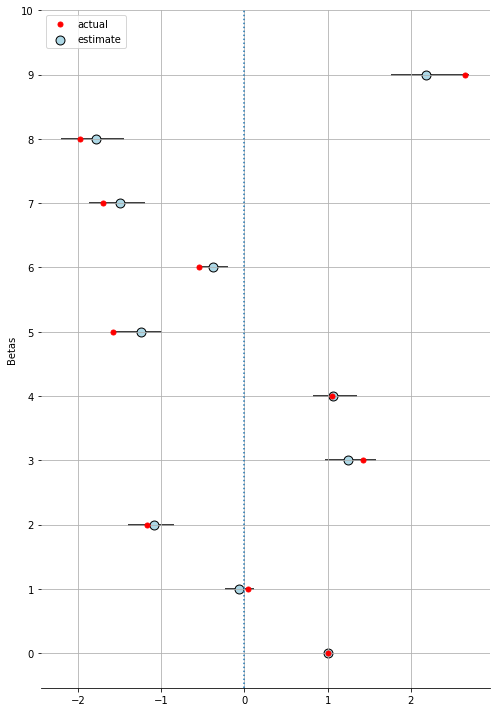

In [272]:
scaled_trace = trace['beta'].squeeze()
scaled_trace = scaled_trace / scaled_trace[:, 0].reshape(-1, 1)
plot_results(scaled_trace, beta_true/beta_true[0])
plt.savefig("../../sidravi1.github.io/assets/20191110_subset_alternatives.png")